# Learning the committor for Alanine with distances as inputs
Reference paper: 
_Kang, Trizio and Parrinello, [Nat Comput Sci](https://doi.org/10.1038/s43588-024-00645-0) (2024), [ArXiv](https://arxiv.org/abs/2401.05279)_

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/committor/docs/notebooks/examples/ex_committor.ipynb)

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# reference values for alanine for plotting
ref = np.load('/home/etrizio/Downloads/refs/alanine_fes.npz')

def convert_model(model_name, n_input):
    loaded_model = torch.jit.load(model_name).to(torch.device('cpu')).to(torch.float32)
    fake_input = torch.rand(n_input).to(torch.float32)
    loaded_model(fake_input)
    frozen_model = torch.jit.trace(loaded_model, fake_input)
    torch.jit.save(frozen_model, model_name)

# Set seed for reproducibility
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

## Initialize common objects for all iterations

#### Variables

In [2]:
from mlcolvar.cvs.committor.utils import initialize_committor_masses 

# initialize the masses vector for the calculation
atomic_masses = initialize_committor_masses(atom_types=[0, 0, 1, 2, 0, 0, 0, 1, 2, 0], 
                                            masses=[12.011, 15.999, 14.007], 
                                            n_dims=3)

# number of atoms
n_atoms=10

# temperature in Kelvin
T = 300 

# Boltzmann factor in the RIGHT ENERGY UNITS!
kb = 0.0083144621 # kJ/mol
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

Beta: 0.4009078751268027 
1/beta: 2.4943386299999997


#### Descriptors calculations
Here we use pairwise distances between the heavy atoms of the molecule

In [3]:
from mlcolvar.core.transform import PairwiseDistances

# simulation cell 
cell = torch.Tensor([3.0233, 3.0233, 3.0233])
print('Cell: ', cell)

# initialize object to compute distances
ComputeDistances = PairwiseDistances(n_atoms=10, 
                                     PBC=True, 
                                     cell=cell, 
                                     scaled_coords=True)

Cell:  tensor([3.0233, 3.0233, 3.0233])


# Iter 0: Unbiased data only 

#### Load data
Here we first load the data, then we assign the correct weights and then we setup precompute the derivatives of the descriptors wrt positions so that we can only do it once and speed up the calculations during the training.

In [4]:
from mlcolvar.data import DictModule, DictDataset
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights
from mlcolvar.core.loss.committor_loss import compute_descriptors_derivatives, SmartDerivatives
 
folder = '/home/etrizio/Downloads'
filenames = ['./unbiased_sims/COLVAR_A',
             './unbiased_sims/COLVAR_B',
            ]

load_args = [{'start' : 0, 'stop': 10000, 'stride': 5},
             {'start' : 0, 'stop': 10000, 'stride': 5},
            ]           

# load data
dataset, dataframe = create_dataset_from_files(file_names = filenames,
                                               folder = folder,
                                               create_labels = True,
                                               filter_args={'regex' : 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'},
                                               return_dataframe = True,
                                               load_args=load_args,
                                               verbose = True)

# zeroth iteration should be unbiased, we thus initialize the bias as zero
bias = torch.zeros(len(dataset))

# compute weights
dataset = compute_committor_weights(dataset, bias, [0, 1], beta)


# apply preprocessing and compute derivatives of descriptors
pos, desc, d_desc_d_x = compute_descriptors_derivatives(dataset=dataset, 
                                                        descriptor_function=ComputeDistances, 
                                                        n_atoms=n_atoms, 
                                                        separate_boundary_dataset=False)

# this sets up the fixed part of the calculation of the derivatives
smart_derivatives = SmartDerivatives(d_desc_d_x, 
                                     n_atoms=n_atoms, 
                                     setup_device='cpu')

# update dataset with the descriptors as data
smart_dataset = DictDataset({'data' : desc.detach(), 
                             'labels': torch.clone(dataset['labels']), 
                             'weights' : torch.clone(dataset['weights'])})

# initialize datamodule, shuffle and random_split must be False as SmartDerivatives doesn't support shuffling, yet
datamodule = DictModule(smart_dataset, lengths=[1], shuffle=False, random_split=False)

Class 0 dataframe shape:  (2000, 91)
Class 1 dataframe shape:  (2000, 91)

 - Loaded dataframe (4000, 91): ['time', 'phi', 'psi', 'theta', 'ene', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'p1.a', 'p1.b', 'p1.c', 'p2.a', 'p2.b', 'p2.c', 'p3.a', 'p3.b', 'p3.c', 'p4.a', 'p4.b', 'p4.c', 'p5.a', 'p5.b', 'p5.c', 'p6.a', 'p6.b', 'p6.c', 'p7.a', 'p7.b', 'p7.c', 'p8.a', 'p8.b', 'p8.c', 'p9.a', 'p9.b', 'p9.c', 'p10.a', 'p10.b', 'p10.c', 'cell.ax', 'cell.ay', 'cell.az', 'cell.bx', 'cell.by', 'cell.bz', 'cell.cx', 'cell.cy', 'cell.cz', 'walker', 'labels']
 - Descriptors (4000, 30): ['p1.a', 'p1.b', 'p1.c', 'p2.a', 'p2.b', 'p2.c', 'p3.a', 'p3.b', 'p3.c', 'p4.a', 'p4.b', 'p4.c', 'p5.a', 'p5.b', 'p5.c', 'p6.a', 'p6.b', 'p6.c', 'p7.a', 'p7.b'

/home/etrizio/Bin/dev/mlcolvar/mlcolvar/data/datamodule.py:133: UserWarning: A torch.generator was provided but it is not used with random_split=False
  warnings.warn(


#### Visualize training set in $\phi\psi$ plane

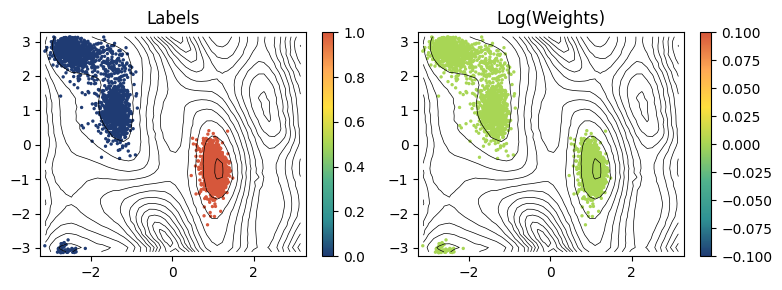

In [5]:
from mlcolvar.utils.plot import paletteFessa

fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot labels
ax = axs[0]
ax.set_title('Labels')
ax.contour(ref['bins1'], ref['bins2'], ref['fes'], 15, colors='k', linewidths=0.5)
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=dataset['labels'], cmap='fessa', s=2)
plt.colorbar(cp, ax=ax)

# plot weights
ax = axs[1]
ax.set_title('Log(Weights)')
ax.contour(ref['bins1'], ref['bins2'], ref['fes'], 15, colors='k', linewidths=0.5)
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=torch.log(dataset['weights']), cmap='fessa', s=2)
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

#### Initialize model

In [9]:
from mlcolvar.cvs import Committor
import copy

# initialize lr scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR

# create options dictionary
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.9999 },
            'nn' : {'activation' : 'tanh'}}

# initialize model
model = Committor(layers=[45, 32, 32, 1],
                         mass=atomic_masses,
                         alpha=1e1,
                         options=options, 
                         separate_boundary_dataset=False,           # this to separate dataset, by default True
                         descriptors_derivatives=smart_derivatives  # this makes the calculation of the variational loss faster
                         )

# copy the last layer sigmoid activation function so we can enable/disable it
Sigmoid = copy.copy(model.sigmoid)

/home/etrizio/Bin/miniconda3/envs/mlcolvar_dev/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'descriptors_derivatives' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['descriptors_derivatives'])`.


#### Train model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type           | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | train | ?        | ?        
1 | nn      | FeedForward    | 2.6 K  | train | [1, 45]  | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | train | [1, 1]   | [1, 1]   
--------------------------------------------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.58it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


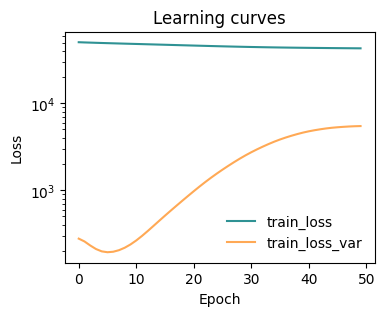

In [10]:
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics

# define callbacks
metrics = MetricsCallback()

# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000
trainer = lightning.Trainer(callbacks=[metrics], 
                            max_epochs=50, 
                            logger=False, 
                            enable_checkpointing=False,
                            limit_val_batches=0,    # this to skip validation
                            num_sanity_val_steps=0  # this to skip validation
                            )

# fit model
trainer.fit(model, datamodule)

# plot metrics
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1', 'fessa5'],
                  yscale='log',
                  ax = ax)

#### Visualize results

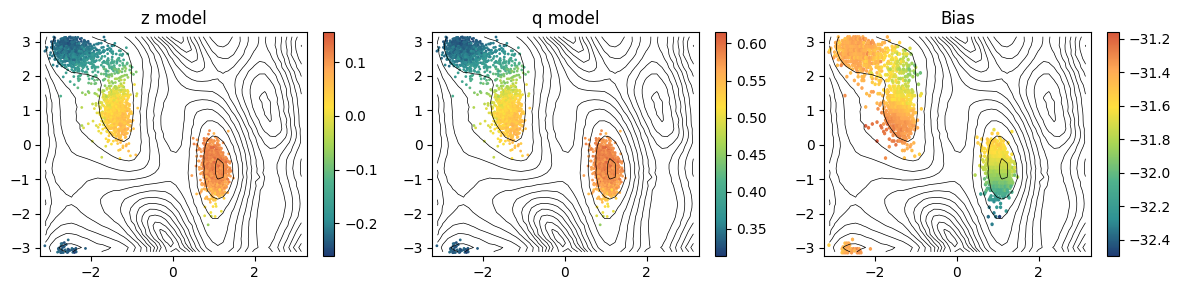

In [11]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

fig, axs = plt.subplots(1,3,figsize=(12,3))

# plot z --> activation off, directly distances as inputs
model.sigmoid = None
model.preprocessing = ComputeDistances

ax = axs[0]
ax.set_title('z model')
aux = model(dataset['data'])
cp = ax.scatter(dataframe['phi'], dataframe['psi'], c=aux.cpu().detach().numpy(), s=1, cmap='fessa')
ax.contour(ref['bins1'], ref['bins2'], ref['fes'], 15, colors='k', linewidths=0.5)
plt.colorbar(cp, ax=ax)


# plot q --> activation on, directly distances as inputs
model.sigmoid = Sigmoid
model.preprocessing = ComputeDistances

ax = axs[1]
ax.set_title('q model')
aux = model(dataset['data'])
cp = ax.scatter(dataframe['phi'], dataframe['psi'],c=aux.cpu().detach().numpy(), s=1, cmap='fessa')
ax.contour(ref['bins1'], ref['bins2'], ref['fes'], 15, colors='k', linewidths=0.5)
plt.colorbar(cp, ax=ax)


# plot Kolmogorov bias --> activation on, distances as inputs as we do in PLUMED
model.sigmoid = Sigmoid
model.preprocessing = ComputeDistances

ax = axs[2]
ax.set_title('Bias')
bias_model = KolmogorovBias(model, lambd=2, beta=1)
aux = bias_model((dataset['data']))
cp = ax.hexbin(dataframe['phi'], dataframe['psi'], C=aux.cpu().detach().numpy(), cmap='fessa')
ax.contour(ref['bins1'], ref['bins2'], ref['fes'], 15, colors='k', linewidths=0.5)
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

#### Export trained model to torchscript

In [12]:
iter = 0

# turn of preprocessing as in PLUMED we precompute the descriptors to make it faster
model.preprocessing = None

# export z model --> activation off
model.sigmoid = None
model.to_torchscript(f'models/model_{iter}_z.pt', method='trace')
convert_model(f'models/model_{iter}_z.pt', 45)

# export q model --> activation on
model.sigmoid = Sigmoid()
model.to_torchscript(f'models/model_{iter}_q.pt', method='trace')
convert_model(f'models/model_{iter}_q.pt', 45)

FileNotFoundError: [Errno 2] No such file or directory: '/home/etrizio/Bin/dev/mlcolvar/docs/notebooks/examples/models/model_0_z.pt'

#### Run plumed simulations
Here it is convient to create a submission script that updates the input file depending on the iteration you ar at and launches the simulations.

One good approach is to have a template simulation folder with all the inputs and then call the models, simulations folder etc. with progressive names based on the iterations. 
This way it is easy to write a script that depending on the iteration yuo are it changes the few parts that need to be changed in the input files.

For example:


`RUN_SIMULATION = f"cd biased_sims && bash generate_and_run_sims.sh {iter}"`

`subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash')`

#### Visualize sampling
Having a structure makes it also easier to load the simulation results.

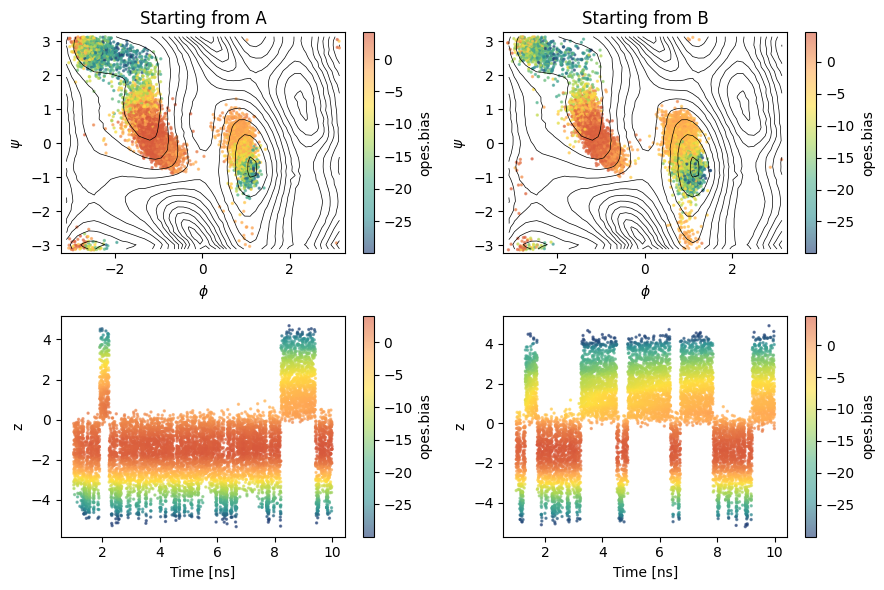

In [ ]:
from mlcolvar.utils.io import load_dataframe

iter=0

sampling = load_dataframe([f'biased_sims/iter_{iter}/A/COLVAR', 
                           f'biased_sims/iter_{iter}/B/COLVAR'], 
                           start=1000)

fig, axs = plt.subplots(2,2,figsize=(9,6))

for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    ax.set_title(f'Starting from {s}')
    ax.set_xlabel('$\phi$')
    ax.set_ylabel('$\psi$')
    cp = ax.contour(ref['bins1'], ref['bins2'], ref['fes'], 15, colors='k', linewidths=0.5)
    temp = sampling[sampling['walker'] == i]
    cp = ax.scatter(temp['phi'], temp['psi'], c=temp['opes.bias'], cmap='fessa',s=2, alpha=0.6)
    plt.colorbar(cp, ax=ax, label='opes.bias')

    ax = axs[1, i]
    ax.set_xlabel('Time [ns]')
    ax.set_ylabel('z')
    cp = ax.scatter(temp['time']/1000, temp['z.node-0'], c=temp['opes.bias'], cmap='fessa',s=2, alpha=0.6)
    plt.colorbar(cp, ax=ax, label='opes.bias')

plt.tight_layout()
plt.show()